In [71]:
# Import necessary packages
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, grid)
from gerrychain.metrics import mean_median, partisan_bias, polsby_popper, efficiency_gap
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import inspect
import pickle
import geopandas as gp
from shapely.geometry import LineString, Polygon
from shapely.ops import unary_union

In [2]:
# Import tools file
from gerrymandering_tools import *

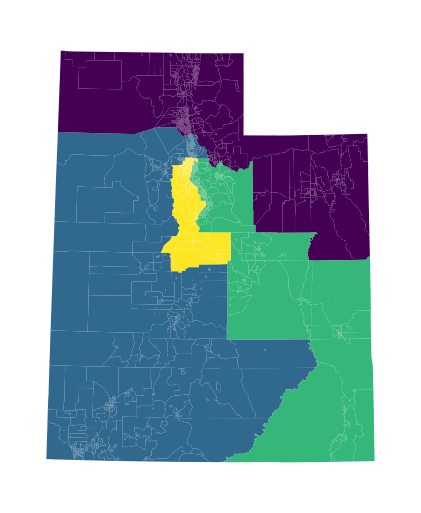

In [3]:
# Get the graph data from the file
utah = Graph.from_json("2012_with_buffer_graph-2020-02-18.json")

# Define our updaters    
my_updaters = {"population": updaters.Tally("POP100", alias="population"), 
               "d": updaters.Tally("DEM", alias="d"),
               "r": updaters.Tally("REP", alias="r"),
               "polsby_popper": polsby_popper,
              }
    
# Define our initial partition
initial_partition = GeographicPartition(utah, "US_Distric", my_updaters)

# Get the precincts
with open("2018_precincts_with_pop_and_prorated_votes.pkl",'rb') as f:
    precincts = pickle.load(f)
    
# Get the shapefile data
g = gp.read_file("2012_dists-Copy1.shp")
    
# Plot the current congressional district map
plot_district_map(initial_partition.assignment, precincts=precincts)

In [4]:
def flatten1(cc):
    new = []
    for part in cc:
        for subpart in part:
            new.append(subpart)
    return new

def get_one_neighbor(graph, precincts):
    """
    Get all the one-neighbor precincts in a graph. 
    
    Parameters:
        graph (nx.Graph): adjacency graph for precincts
        precincts (gp.GeoDataFrame): geoDataFrame with precinct information
        
    Returns:
        num_neighbors: an array mapping numbers of neighbors to numbers of precincts with that many neighbors (for histogram)
        ids: array of one-neighbor precincts
        neighbor_ids: array of their neighbors' ids
        containers: a dictionary mapping nodes adjacent to one-neighbor precincts to those precinct(s)
        dissolve: an array of length len(precints) constructed to be able to dissolve the precincts geoDataFrame
    """
    
    # Set parameters
    num_neighbors = np.zeros(35)
    ids, neighbor_ids = [], []
    containers = {}
    
    # Iterate through nodes
    for node in graph:
        neighbors = len(graph[node])
        num_neighbors[neighbors] += 1
    
        # Is it a one-neighbor node?
        if neighbors == 1:
            neighbor = list(graph[node].keys())[0]
            print("Node: ", node, ", Neighbor: ", neighbor, ", County: ", counties[graph.nodes[node]["CountyID"]], )
        
            # Mark it
            ids.append(node)
            neighbor_ids.append(neighbor)
            
            # Mark its container
            if neighbor not in containers.keys():
                containers[neighbor] = [node]
            else:
                containers[neighbor].append(node)
        
    ids = np.array(ids)
    neighbor_ids = np.array(neighbor_ids)
    
    print("Total: "+str(int(num_neighbors[1])))
    
    # Construct the dissolve array
    
    counter = -1
    dissolve = np.zeros(len(g), dtype=np.int32)

    # Iterate through nodes
    for node in graph:
        if node not in ids:
            counter += 1
            dissolve[node] = counter 
        
        if node in containers.keys():
            for isolated in containers[node]:
                dissolve[isolated] = counter
    
    return num_neighbors, ids, neighbor_ids, containers, dissolve

In [5]:
# Find all the one-neighbor precincts
lengths, ids, neighbor_ids, containers, dissolve = tqdm(get_one_neighbor(initial_partition.graph, g))

Node:  35 , Neighbor:  52 , County:  Tooele
Node:  36 , Neighbor:  74 , County:  Tooele
Node:  86 , Neighbor:  87 , County:  Emery
Node:  88 , Neighbor:  89 , County:  Emery
Node:  90 , Neighbor:  91 , County:  Emery
Node:  102 , Neighbor:  103 , County:  Emery
Node:  168 , Neighbor:  158 , County:  Garfield
Node:  169 , Neighbor:  164 , County:  Garfield
Node:  171 , Neighbor:  165 , County:  Garfield
Node:  172 , Neighbor:  162 , County:  Garfield
Node:  173 , Neighbor:  163 , County:  Garfield
Node:  200 , Neighbor:  195 , County:  Wayne
Node:  201 , Neighbor:  198 , County:  Wayne
Node:  202 , Neighbor:  194 , County:  Wayne
Node:  203 , Neighbor:  197 , County:  Wayne
Node:  204 , Neighbor:  196 , County:  Wayne
Node:  216 , Neighbor:  217 , County:  Box Elder
Node:  271 , Neighbor:  252 , County:  Box Elder
Node:  272 , Neighbor:  220 , County:  Box Elder
Node:  273 , Neighbor:  219 , County:  Box Elder
Node:  274 , Neighbor:  218 , County:  Box Elder
Node:  326 , Neighbor:  287 

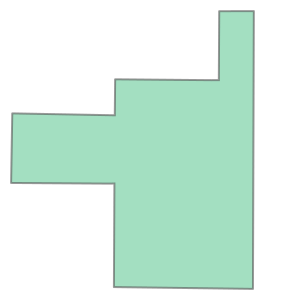

In [6]:
# 35 / 52, 36 / 74
g.iloc[36]['geometry']

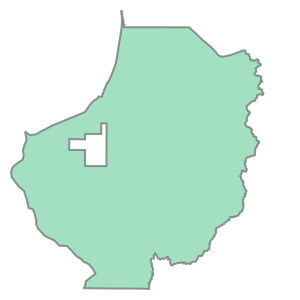

In [7]:
g.iloc[74]['geometry']

Text(0, 0.5, 'Number of Precincts')

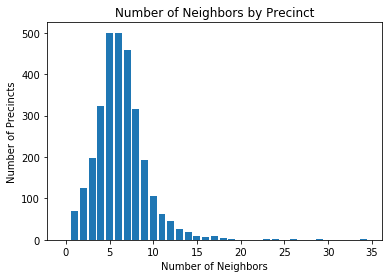

In [8]:
plt.bar(np.arange(35), lengths)
plt.title("Number of Neighbors by Precinct")
plt.xlabel("Number of Neighbors")
plt.ylabel("Number of Precincts")

(206337.84766411144, 696213.6725121047, 4066800.310246099, 4681515.28842151)

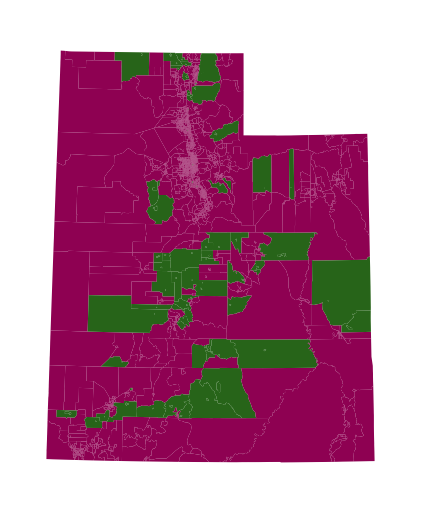

In [9]:
# Mark the one-neighbor nodes
slice_to_set = np.zeros(len(g))
slice_to_set[ids] = 1
slice_to_set[neighbor_ids] = 1
g["one neighbor"] = slice_to_set

# Plot the one neighbor precincts with their one neighbor
size, dpi =(3,2), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
g.plot(column='one neighbor', ax=ax, cmap='PiYG')
plt.axis("off")

In [10]:
def perform_dissolve_gdf(precincts, dissolve):
    """
    Dissolves one-neighbor precincts and returns the merged GeoDataFrame.
    
    Parameters:
        precincts: GeoDataFrame of precinct data
        dissolve: a column containing the merge information
    
    Returns:
        merged (GeoDataFrame): a new merged GeoDataFrame
    """
    
    # Dissolve the one-neighbor precincts into their containers
    
    precincts['dissolve'] = dissolve

    merged = precincts.dissolve(by='dissolve', aggfunc=['sum', 'first'])
    
    merged.drop([('CountyID', 'sum'), ('VistaID', 'first'), ('AliasName', 'sum'), ('RcvdDate', 'sum'), 
                 ('PrecinctID', 'sum'), ('PrecinctID', 'first'),
                 ('SHAPE_Leng', 'first'), ('SHAPE_Area', 'first'), ('SHAPE_Leng', 'sum'), ('SHAPE_Area', 'sum'),
                 ('POP100', 'first'), ('DEM', 'first'), ('REP', 'first'), ('US_Distric', 'sum'), 
                 ('UT_STATE', 'sum'), ('UT_HOUSE', 'first'), ('one neighbor', 'sum')], axis=1, inplace=True)
    
    merged.columns = ['geometry', 'CountyID', 'VistaID', 'AliasName', 'RcvdDate','POP100', 'DEM', 'REP', 'US_Distric', 'UT_STATE', 'UT_HOUSE', 'one neighbor']
    
    return merged

In [11]:
utah.nodes[247]

{'boundary_node': False,
 'area': 4530941.478030959,
 'CountyID': 2,
 'VistaID': 'BC14',
 'PrecinctID': 'BC14',
 'SubPrecinc': None,
 'VersionNbr': None,
 'EffectiveD': '2013-05-31',
 'AliasName': None,
 'Comments': 'myoung',
 'RcvdDate': '2013-05-31',
 'SHAPE_Leng': 10983.805611,
 'SHAPE_Area': 4508963.2222,
 'POP100': 1265.0,
 'DEM': 59.0,
 'REP': 170.0,
 'US_Distric': 0,
 'UT_STATE': 8,
 'UT_HOUSE': 21}

In [12]:
def perform_dissolve_graph(graph, dissolve, separators):
    
    # Merge the graphs
    n = len(graph)
    
    # Construct a dictionary from the dissovle array
    dissolve_dict = {tup[0]:tup[1] for tup in enumerate(dissolve)} # old_id --> new_id
    
    # Get the images of separators under the "dissolve" mapping
    images_of_separators = set(dissolve[np.array(list(separators.keys()))])
    
    # Relabel the nodes
    new_graph = nx.relabel.relabel_nodes(graph, dissolve_dict)
    
    # Relabel the attributes
    for new_id in dissolve_dict:
        if new_id in images_of_separators:
            # We have to fix the attributes
            
            original_nodes = list(np.nonzero(dissolve == new_id)[0])
            
            # Set attributes
            
            new_graph.nodes[new_id]['boundary_node'] = any(graph.nodes[i]['boundary_node'] for i in original_nodes)
            new_graph.nodes[new_id]['area'] = sum(graph.nodes[i]['area'] for i in original_nodes)
            # CountyID should be preserved in any case
            new_graph.nodes[new_id]['VistaID'] = ', '.join([str(graph.nodes[i]['VistaID']) for i in original_nodes])
            new_graph.nodes[new_id]['PrecinctID'] = ', '.join([str(graph.nodes[i]['PrecinctID']) for i in original_nodes])
            new_graph.nodes[new_id]['SubPrecinc'] = ', '.join([str(graph.nodes[i]['SubPrecinc']) for i in original_nodes])
            try:
                new_graph.nodes[new_id]['VersionNbr'] = 1+max(graph.nodes[i]['VersionNbr'] for i in original_nodes)
            except:
                pass
            new_graph.nodes[new_id]['EffectiveD'] = '2020-04'
            # AliasName should be preserved in any case
            new_graph.nodes[new_id]['Comments'] = 'merged, 2020-04'
            new_graph.nodes[new_id]['RcvdDate'] = '2020-04'
            new_graph.nodes[new_id]['SHAPE_Leng'] = max(graph.nodes[i]['SHAPE_Leng'] for i in original_nodes)
            new_graph.nodes[new_id]['SHAPE_Area'] = sum(graph.nodes[i]['SHAPE_Area'] for i in original_nodes)
            new_graph.nodes[new_id]['POP100'] = sum(graph.nodes[i]['POP100'] for i in original_nodes)
            new_graph.nodes[new_id]['DEM'] = sum(graph.nodes[i]['DEM'] for i in original_nodes)
            new_graph.nodes[new_id]['REP'] = sum(graph.nodes[i]['REP'] for i in original_nodes)
            # US_District will be preserved
        else:
            # This node was not merged, no attribute changes required
            pass
    
    return new_graph

In [13]:
list(np.nonzero(dissolve == 498)[0])

[547, 2973]

In [14]:
merged = perform_dissolve_gdf(g, dissolve)

C:\Users\Jacob\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


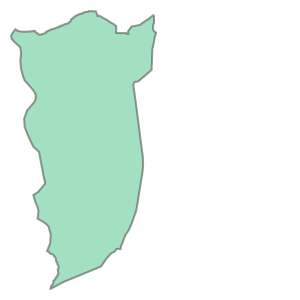

In [15]:
merged.iloc[50]["geometry"]

(206337.84766411144, 696213.6725121047, 4066800.310246099, 4681515.28842151)

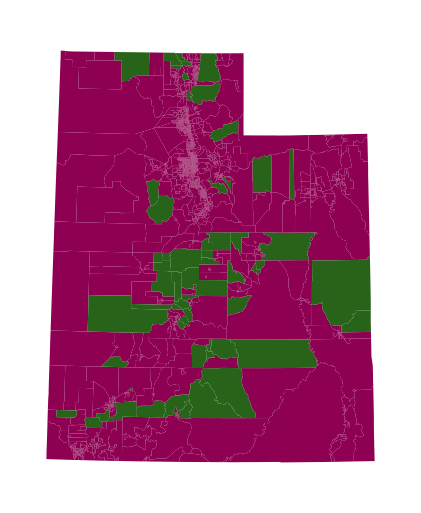

In [16]:
size, dpi =(3,2), 300
fig, ax = plt.subplots(figsize=size, dpi=dpi)
merged.plot(column='one neighbor', ax=ax, cmap='PiYG')
plt.axis("off")

In [17]:
len(g) - len(merged)

70

# But there are some precincts that contain more than one adjacent precinct. How do we find these?

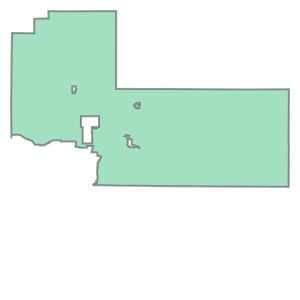

In [18]:
# For example, this precinct, which contains 5 other precincts, 
# two of which are adjacent, so they are not "one neighbor precincts"

g.iloc[450]['geometry']

In [19]:
def get_separators(graph, precincts):
    """
    Get all the precincts in the graph which, upon removal, separate the graph into 
    multiple components. For example, if one precinct completely contains two others, 
    but they each border each other, then they will each have two neighbors. However, 
    there is no continguous districting plan in which they (and their containing precinct) 
    are in the same district.
    
    Parameters:
        graph (nx.Graph): adjacency graph for precincts
        precincts (gp.GeoDataFrame): geoDataFrame with precinct information
        
    Returns:
        ids: array of one-neighbor precincts
        neighbor_ids: array of their neighbors' ids
        separations: a dictionary mapping separating nodes to the precincts they separate from the graph
        dissolve: an array of length len(precints) constructed to be able to dissolve the precincts geoDataFrame
    """
    
    # Set parameters
    num_neighbors = np.zeros(35)
    ids, neighbor_ids = [], []
    separations = {}
    
    for node in graph:
        
        neighbors = len(graph[node])
        num_neighbors[neighbors] += 1
        
        copy = graph.copy()
        copy.remove_node(node)
        
        # See if the graph becomes disconnected by removing a particular node
        cc = list(nx.connected_components(copy))
        
        if len(cc) != 1:
            neighbor_ids.append(node)
            disconnected_nodes = flatten1(cc[1:])
            separations[node] = disconnected_nodes
            for n in disconnected_nodes:
                ids.append(n)
        
    ids = np.array(ids)
    neighbor_ids = np.array(neighbor_ids)
    
    print("Total: "+str(int(len(ids))))
    
    # Construct the dissolve array
    
    counter = -1
    dissolve = np.zeros(len(g), dtype=np.int32)

    # Iterate through nodes
    for node in graph:
        if node not in ids:
            counter += 1
            dissolve[node] = counter 
        
        if node in separations.keys():
            for isolated in separations[node]:
                dissolve[isolated] = counter
    
    return ids, neighbor_ids, separations, dissolve

In [20]:
# Find all the separating precincts, < 5 min
ids2, neighbor_ids2, separators, dissolve2 = tqdm(get_separators(initial_partition.graph, g))

Total: 79


In [21]:
# Make sure it is performing correctly

# This should print nothing
for node in neighbor_ids:
    if node not in neighbor_ids2:
        print(node)
        
print('')

# This could print some precincts
for node in neighbor_ids2:
    if node not in neighbor_ids:
        print(node)


444
445
486


(206337.84766411147, 696213.6725121047, 4066800.3102460983, 4681515.28842151)

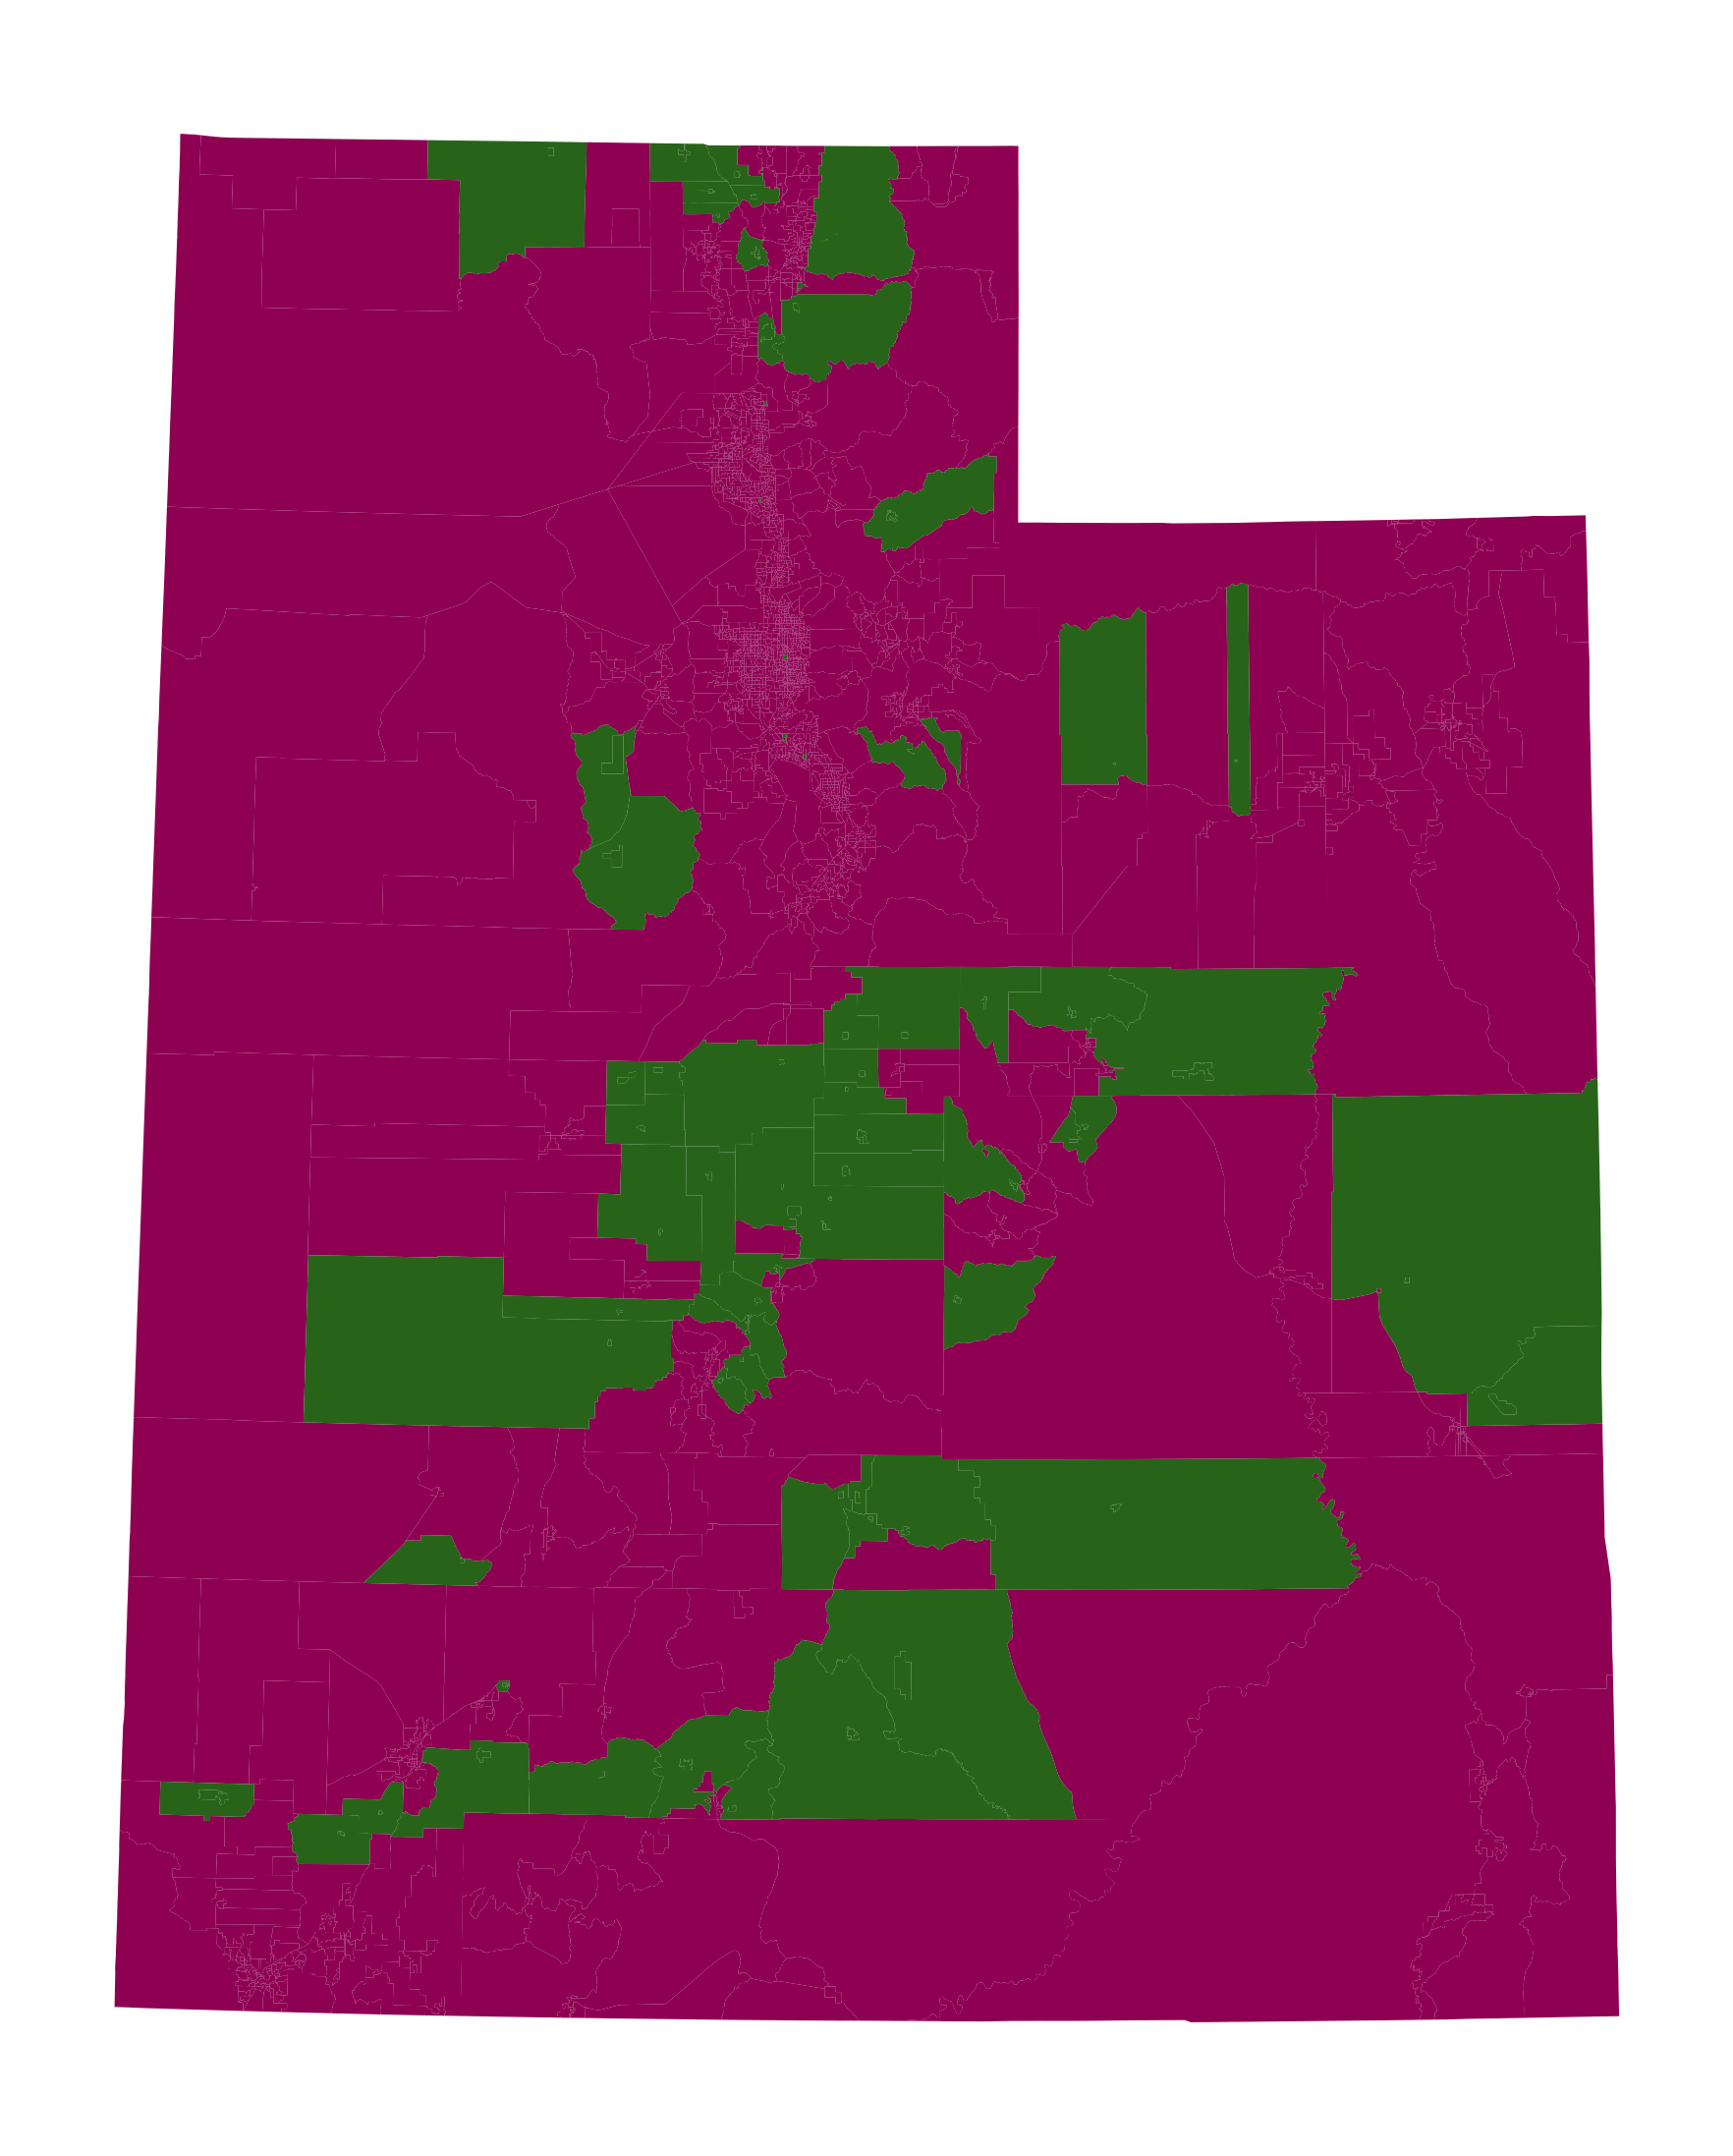

In [22]:
# Mark the separating nodes
slice_to_set = np.zeros(len(g))
slice_to_set[ids2] = 1
slice_to_set[neighbor_ids2] = 1
g["one neighbor"] = slice_to_set

# Plot the offending precincts
size, dpi =(14,7), 400
fig, ax = plt.subplots(figsize=size, dpi=dpi)
g.plot(column='one neighbor', ax=ax, cmap='PiYG')
plt.axis("off")

# plt.savefig("isolated_precincts2.png", dpi=dpi, bbox_inches="tight")

# Look at Sanpete County!

In [23]:
# This is the portion of Utah's area contained in these precincts (which cannot be flipped)
np.sum(g[g['one neighbor'] == 1]['SHAPE_Area'])/np.sum(g['SHAPE_Area'])

0.2048691583329864

In [24]:
# Merge so that the new merged precincts are flippable
merged2 = perform_dissolve_gdf(g, dissolve2)

C:\Users\Jacob\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


(206337.84766411147, 696213.6725121047, 4066800.3102460983, 4681515.28842151)

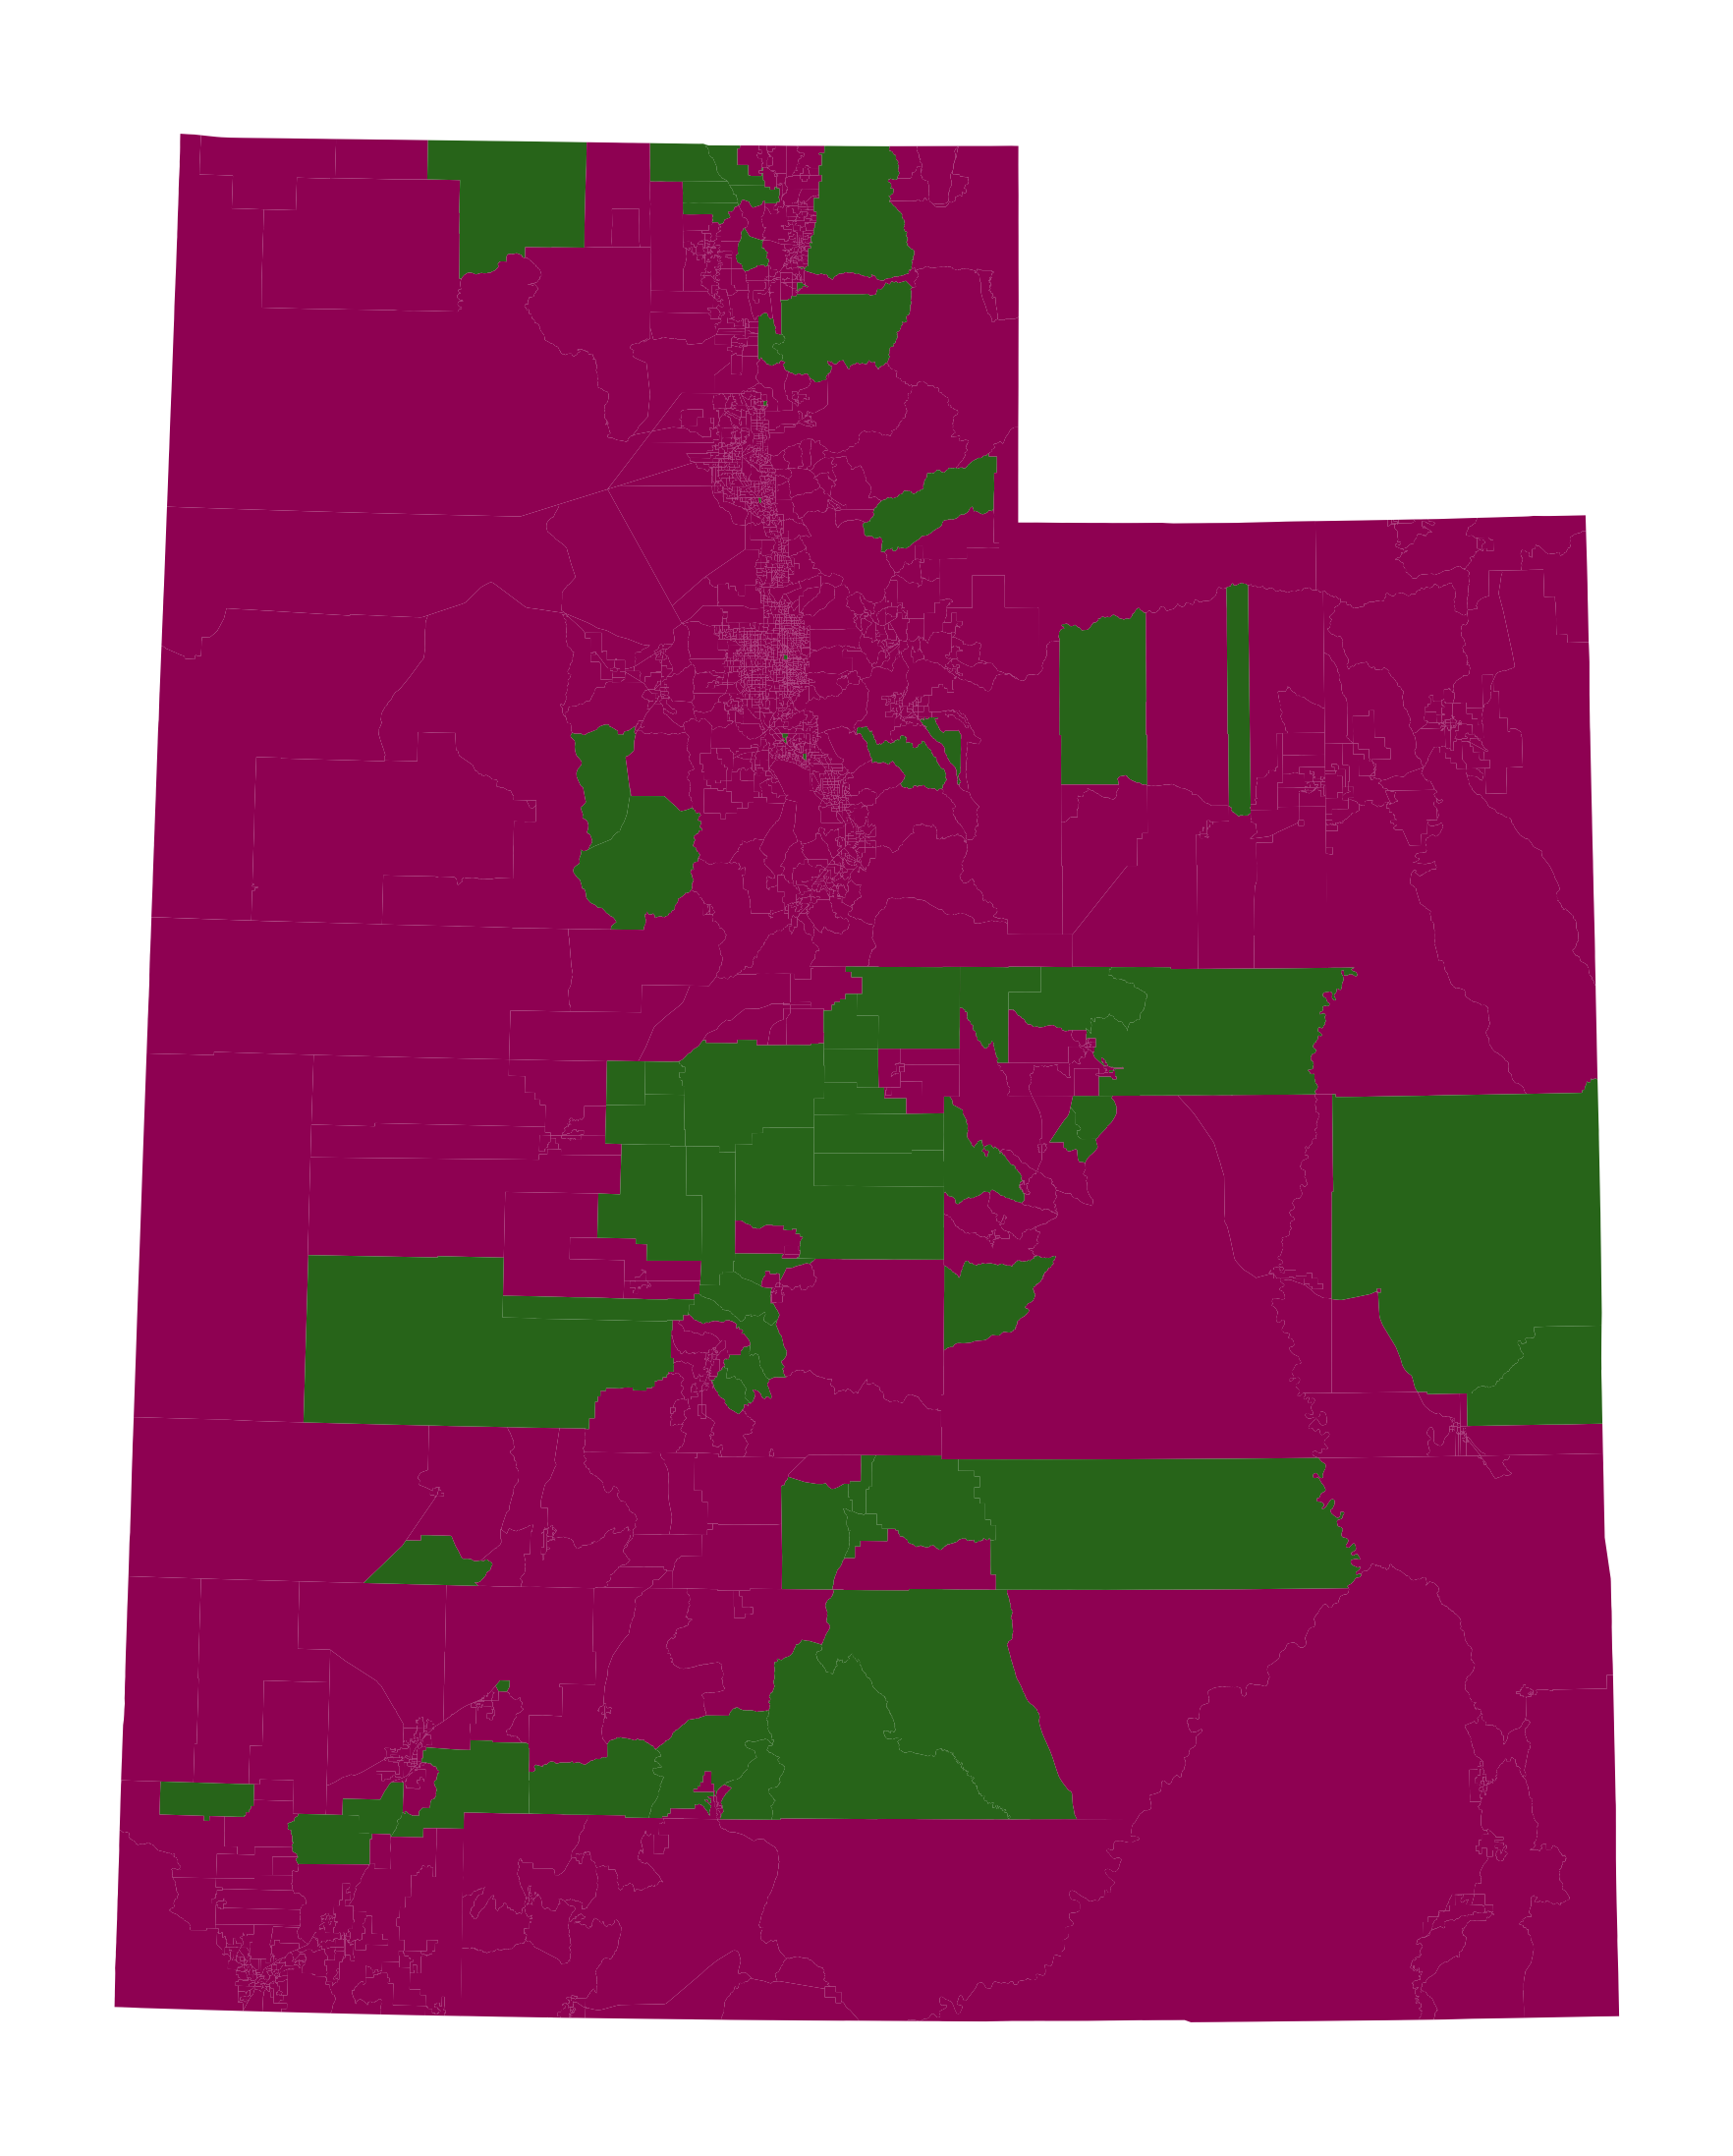

In [25]:
size, dpi = (14,7), 400
fig, ax = plt.subplots(figsize=size, dpi=dpi)
merged2.plot(column='one neighbor', ax=ax, cmap='PiYG')
plt.axis("off")
# plt.savefig("isolated_precincts_merged1.png", dpi=dpi, bbox_inches="tight")

In [26]:
len(g) - len(merged2)

79

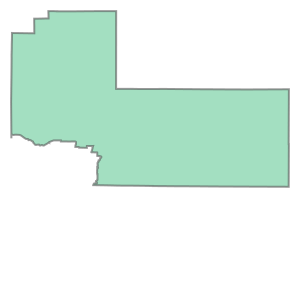

In [27]:
# Take a look at this precinct, the same one I showed before. All of its holes are patched up
merged2.iloc[401]['geometry']

In [28]:
np.array(list(containers.keys()))

array([  52,   74,   87,   89,   91,  103,  158,  164,  165,  162,  163,
        195,  198,  194,  197,  196,  217,  252,  220,  219,  218,  287,
        327,  320,  339,  391,  375,  372,  380,  373,  428,  427,  426,
        417,  418,  419,  420,  450,  454,  455,  456,  449,  487,  485,
        178,  636,  631,  634,  635,  673,  641,  662,  693,  689,  841,
        816,  905,  902, 1057, 1547, 1464, 1543, 1764, 1877, 1934, 2708,
        547])

In [29]:
new_graph = perform_dissolve_graph(utah, dissolve2, containers)

In [49]:
multipolygons = []
for i, poly in enumerate(g['geometry']):
    if type(poly) != Polygon:
        multipolygons.append(i)

In [56]:
len(neighbor_ids2)

70

In [207]:
uintah = g[g['CountyID']==24].copy()

In [208]:
slice_to_set = np.zeros(len(uintah))
slice_to_set[np.array(multipolygons[1:15], dtype=np.int32)-106] = 1
uintah['MPs'] = slice_to_set

In [58]:
np.array(multipolygons)

array([  17,  107,  109,  112,  118,  128,  130,  131,  137,  139,  140,
        141,  146,  152,  156,  161,  175,  235,  238,  239,  242,  248,
        249,  262,  315,  317,  318,  319,  321,  322,  323,  330,  331,
        341,  343,  363,  395,  444,  515,  525,  532,  543,  556,  557,
        569,  599,  602,  604,  607,  610,  613,  615,  624,  630,  634,
        636,  638,  646,  661,  670,  688,  719,  722,  749,  844,  957,
        981, 1004, 1012, 1013, 1014, 1016, 1021, 1051, 1121, 1131, 1138,
       1139, 1145, 1151, 1164, 1171, 1220, 1224, 1229, 1230, 1242, 1256,
       1258, 1280, 1294, 1295, 1315, 1319, 1320, 1345, 1353, 1357, 1360,
       1361, 1369, 1372, 1375, 1393, 1406, 1419, 1423, 1430, 1467, 1502,
       1510, 1515, 1516, 1518, 1523, 1530, 1531, 1548, 1571, 1577, 1600,
       1604, 1605, 1606, 1607, 1608, 1611, 1612, 1613, 1614, 1615, 1616,
       1619, 1623, 1638, 1645, 1646, 1650, 1667, 1688, 1692, 1714, 1715,
       1716, 1729, 1731, 1739, 1749, 1759, 1760, 17

In [63]:
utah[17]

AtlasView({7: {'shared_perim': 11645.585762422981, 'id': 7}, 12: {'shared_perim': 2748.1963313575156, 'id': 12}})

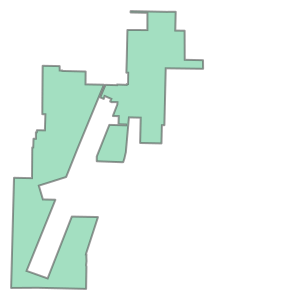

In [88]:
g.iloc[17]['geometry']

In [86]:
utah.nodes[17]

{'boundary_node': True,
 'boundary_perim': 1338.4487784404464,
 'area': 1991609.2898586802,
 'CountyID': 13,
 'VistaID': 'KA1:C',
 'PrecinctID': 'KA1',
 'SubPrecinc': 'C',
 'VersionNbr': None,
 'EffectiveD': '2012-01-01',
 'AliasName': None,
 'Comments': 'kanerds',
 'RcvdDate': '2012-02-02',
 'SHAPE_Leng': 15734.9350327,
 'SHAPE_Area': 1959927.64755,
 'POP100': 14.0,
 'DEM': 1.348459045699825,
 'REP': 3.191169008437474,
 'US_Distric': 1,
 'UT_STATE': 16,
 'UT_HOUSE': 70}

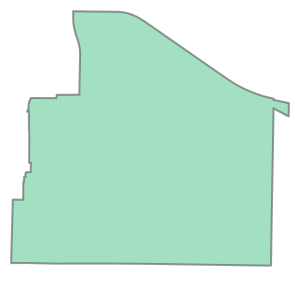

In [85]:
unary_union(list(g.iloc[17]['geometry']) + [g.iloc[7]['geometry']])

In [92]:
counties[24]

'Uintah'

(577504.1008642961, 671837.4585698929, 4360744.05007573, 4532397.949663483)

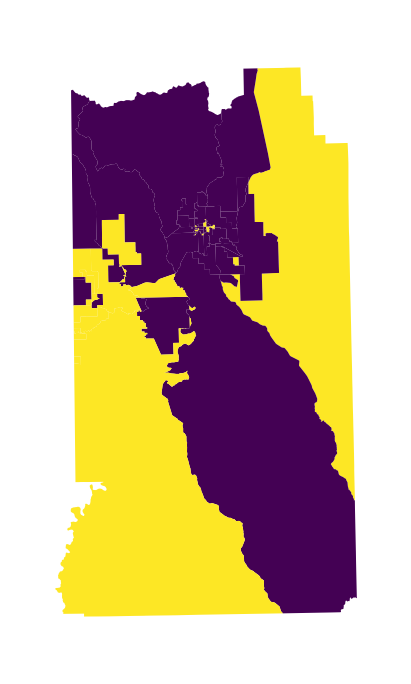

In [209]:
size, dpi = (5,2), 400
fig, ax = plt.subplots(figsize=size, dpi=dpi)
uintah.plot(column='MPs', ax=ax, lw=0.1)
plt.axis("off")

In [124]:
for i in multipolygons:
    print(counties[utah.nodes[i]['CountyID']])

Kane
Uintah
Uintah
Uintah
Uintah
Uintah
Uintah
Uintah
Uintah
Uintah
Uintah
Uintah
Uintah
Uintah
Uintah
Garfield
Juab
Box Elder
Box Elder
Box Elder
Box Elder
Box Elder
Box Elder
Box Elder
Iron
Iron
Iron
Iron
Iron
Iron
Iron
Iron
Iron
Beaver
Beaver
Sevier
Sevier
Sanpete
Cache
Cache
Cache
Cache
Cache
Cache
Cache
Cache
Cache
Cache
Cache
Cache
Cache
Cache
Cache
Cache
Cache
Cache
Duchesne
Duchesne
Duchesne
Duchesne
Wasatch
Wasatch
Wasatch
Washington
Washington
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Davis
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Utah
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber
Weber


In [95]:
utah[109]

AtlasView({117: {'shared_perim': 84366.14018538635, 'id': 109}, 149: {'shared_perim': 10292.450103813442, 'id': 109}, 120: {'shared_perim': 6966.941249859931, 'id': 109}, 116: {'shared_perim': 1682.4560187715322, 'id': 109}, 145: {'shared_perim': 64122.14450952232, 'id': 109}, 133: {'shared_perim': 106.91590150294668, 'id': 109}, 111: {'shared_perim': 37394.69603780772, 'id': 109}, 346: {'shared_perim': 41232.22535074289, 'id': 109}, 344: {'shared_perim': 5639.0590603307155, 'id': 109}})

In [114]:
utah[109][120]['shared_perim']

6966.941249859931

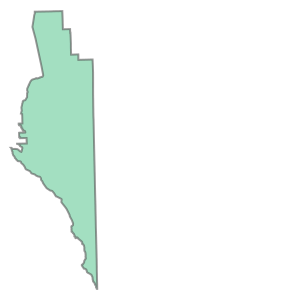

In [112]:
# 120, 145. but 145 has larger shared perimeter
s = unary_union(list(g.iloc[109]['geometry'])+[g.iloc[145]['geometry']])
s

In [120]:
utah[107]

AtlasView({131: {'shared_perim': 335.85108598780147, 'id': 107}, 110: {'shared_perim': 67.72645748347337, 'id': 107}, 144: {'shared_perim': 1286.7394298830716, 'id': 107}, 136: {'shared_perim': 2740.8371883179693, 'id': 107}, 129: {'shared_perim': 495.9286541711503, 'id': 107}, 127: {'shared_perim': 930.8746973863263, 'id': 107}})

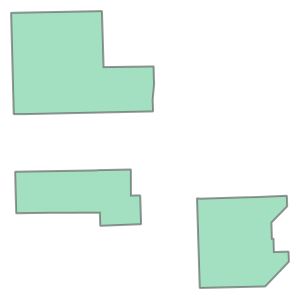

In [182]:
g.iloc[107]['geometry']

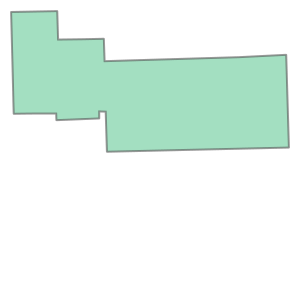

In [135]:
# 144, 136 (136 wins)
s = unary_union(list(g.iloc[107]['geometry'])+[g.iloc[136]['geometry']])
s

In [162]:
utah[112]

AtlasView({139: {'shared_perim': 14946.882667649992, 'id': 112}, 152: {'shared_perim': 237.07107413796467, 'id': 112}, 652: {'shared_perim': 9776.145320814387, 'id': 112}, 130: {'shared_perim': 14860.986024160786, 'id': 112}, 121: {'shared_perim': 147.21378511592985, 'id': 112}, 141: {'shared_perim': 13690.024956528185, 'id': 112}, 128: {'shared_perim': 20564.428364043815, 'id': 112}, 660: {'shared_perim': 1225.4548918975672, 'id': 112}, 151: {'shared_perim': 2758.621843641544, 'id': 112}, 648: {'shared_perim': 3662.3303968536407, 'id': 112}, 643: {'shared_perim': 3243.630318164902, 'id': 112}, 157: {'shared_perim': 5149.91313708552, 'id': 112}})

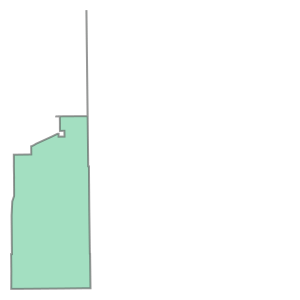

In [169]:
g.iloc[652]['geometry']

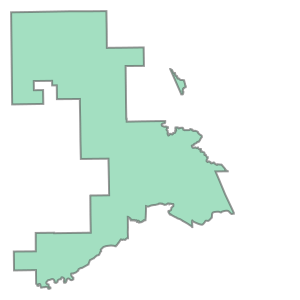

In [171]:
# 652, 121
# 128 looks pretty good?
s = unary_union(list(g.iloc[112]['geometry'])+[g.iloc[128]['geometry']])
s

In [211]:
counter = 0
for i in multipolygons:
    for n in utah[i].keys():
        if n in multipolygons:
            counter += 1
            break
print(counter/len(multipolygons))

0.6327433628318584


In [249]:
set().union(*[])

set()

In [251]:
class Merge:
    
    def __init__(self):
        self.merges = []
        self.merged_objects = set()
    
    def add(self, part):
        assert type(part) == set
        
        self.merged_objects.add(part)
        
        if len(part) <= 1:
            # Do nothing
            pass
        elif self.merges == []:
            self.merges = [part]
        else:
            for i, part2 in enumerate(self.merges):
                intersections = []
                non_intersections = [] 
                if part.intersection(part2) != set():
                    intersections.append(part2)
                else:
                    non_intersections.append(part1)
            
            self.merges = non_intersections + [part.union(*intersections)]
        
    def add_many(self, parts):
        for part in parts:
            self.add(part)
    
    def __add__(self, other):
        
        new = Merge()
        new.add_many(self.merges)
        new.add_many(other.merges)
        
        return new
    
    def find(self, element):
        for part in self.merges:
            if element in part:
                return part
    def __contains__(self, element):
        if type(element) == set:
            return element in self.merges
        elif type(element) == Merge:
            return self + element == self
        else:
            return element in self.merged_objects
    
    def get_dissolve(self, n):
        counter = 0
        dissolve = np.zeros(len(g), dtype=np.int32)

        # Iterate through nodes
        for i in range(n):
            if i not in self:
                dissolve[i] = counter 
                counter += 1
            else:
                s = self.find(i)
                for e in s:
                    dissolve[e] = counter
                
                counter += 1
        
        return dissolve
                
                
                

In [238]:
def clean_merge(merge):
    merge = merge.copy()
    final = []
    for i, part in enumerate(merge):
        intersections = []
        for j, part2 in enumerate(merge):
            if j <= i:
                continue
            
            if part.intersection(part2) != set():
                intersections.append(part2)
                
        

set()

In [223]:
def combine_merges(merge1, merge2):
    final = []
    for part1 in merge1:
        intersections = []
        for part2 in merge2:
            if part1.intersection(part2) == set():
                intersections.append(part2)
        
        if intersections == []:
            
                
                

TypeError: set expected at most 1 arguments, got 2

In [233]:
set1 = set([4,5,6])
set2 = set([5,7,9])

In [241]:
set1.intersection(set2)

set()

In [240]:
set2.remove(5)
set2

{7, 9}

In [230]:
def merge_multipolygons(graph, gdf):
    
    # Find all the multipolygons
    multipolygons = []
    for i, poly in enumerate(gdf['geometry']):
        if type(poly) != Polygon:
            multipolygons.append(i)
    
    # Create a subgraph of multipolygons
    mp_graph = graph.subgraph(multipolygons)
    
    merges = []
    
    # Iterate over the multipolygons
    for mp in multipolygons:
        
        # Determine whether any of its neighbors are multipolygons
        single_mp = True
        for n in graph[mp].keys():
            if n in multipolygons:
                single_mp = False
                break
        
        # If no neighbors are multipolygons
        if single_mp:
            
            possibilities = []
            for n in graph[mp].keys():
                # Merge an adjacent polygon
                s = unary_union(list(gdf.iloc[mp]['geometry']) + [gdf.iloc[n]['geometry']])
                
                # If the merge worked, store it as a possibility
                if type(s) == Polygon:
                    possibilities.append(n)
            
            # Find argmax graph[mp][p]['shared_perim'] for p in possibilities
            if len(possibilities) >= 1:
                best = possibilities[np.argmax([graph[mp][p]['shared_perim'] for p in possibilities])]
                merges.append(set([mp, best]))
            
            else:
                print(mp)
                
        
    return merges      
                


In [231]:
merges1 = merge_multipolygons(utah, g)

ValueError: attempt to get argmax of an empty sequence

In [229]:
merges1

[{7, 17}]

In [222]:
list(nx.connected_components(utah.subgraph(multipolygons)))

[{515, 599, 607, 610},
 {2052, 2079},
 {1258, 1320, 1515, 1548, 1604, 1605, 1606, 1619},
 {525, 532, 557, 569, 602, 604, 613, 615, 636},
 {17},
 {2066},
 {2067, 2107},
 {1004, 1012, 1013, 1016, 1051, 1164, 1220},
 {2078},
 {543},
 {1280, 1319, 1360, 1361, 1423, 1467, 1523, 1571},
 {1372, 1393, 1577},
 {556},
 {2029, 2606, 2641},
 {2045},
 {2103},
 {2108},
 {2413, 2622, 2850, 2856, 2896, 2930},
 {1600},
 {1607, 1608},
 {2121},
 {2634, 2833, 2898},
 {1611},
 {1375, 1612},
 {1430, 1613},
 {1614, 1615},
 {1616},
 {1518, 1623},
 {1121},
 {2146},
 {1638, 1645, 1650},
 {2665},
 {1131},
 {107, 131},
 {109},
 {1646, 1812},
 {112, 128, 130, 139, 141, 152, 156, 638, 646, 661, 670},
 {624, 630},
 {1138, 1139},
 {118, 137, 140, 146},
 {1145},
 {634},
 {2684, 2895},
 {1151},
 {1667},
 {2191},
 {1171},
 {1688,
  1692,
  1714,
  1731,
  1763,
  1765,
  1770,
  1783,
  1808,
  1810,
  1816,
  1822,
  1824,
  1828},
 {161},
 {2726},
 {175},
 {688, 719, 722},
 {2735},
 {1715},
 {1716},
 {1729},
 {2754},


In [30]:
def plot_graph(precincts, graph, node_size=1, line_size=0.1, dpi=400, size=7, save=False, savetitle=None):
   
    precincts['color'] = precincts.index % 20  # fix the coloring of the precincts
    precincts['center'] = precincts.centroid   # the location of the nodes
    nodes = gp.GeoDataFrame(geometry=precincts.center)    # make a GeoDataFrame of nodes
    E = [LineString([precincts.loc[a,'center'],precincts.loc[b,'center']])
         for a,b in list(graph.edges)]         # Construct a line for each edge
    edges = gp.GeoDataFrame(list(graph.edges),geometry=E) # make a geoDataFrame of edges
   
    fig = plt.figure(dpi=dpi)               # Set up the figure
    fig.set_size_inches(size,size*2)        # Make it have the same proportions as Utah
    ax = plt.subplot(1,1,1)                                  

    precincts.plot('color',cmap='tab20', ax=ax,alpha=0.5)   # Plot precincts
    nodes.plot(ax=ax,color='k', markersize=0.1)               # Plot nodes
    edges.plot(ax=ax,lw=0.05,color='k')                      # plot edges
    plt.axis('off');                                        # no coordinates
    
    if save: plt.savefig(savetitle, bbox_inches='tight', dpi=dpi)       # Save it

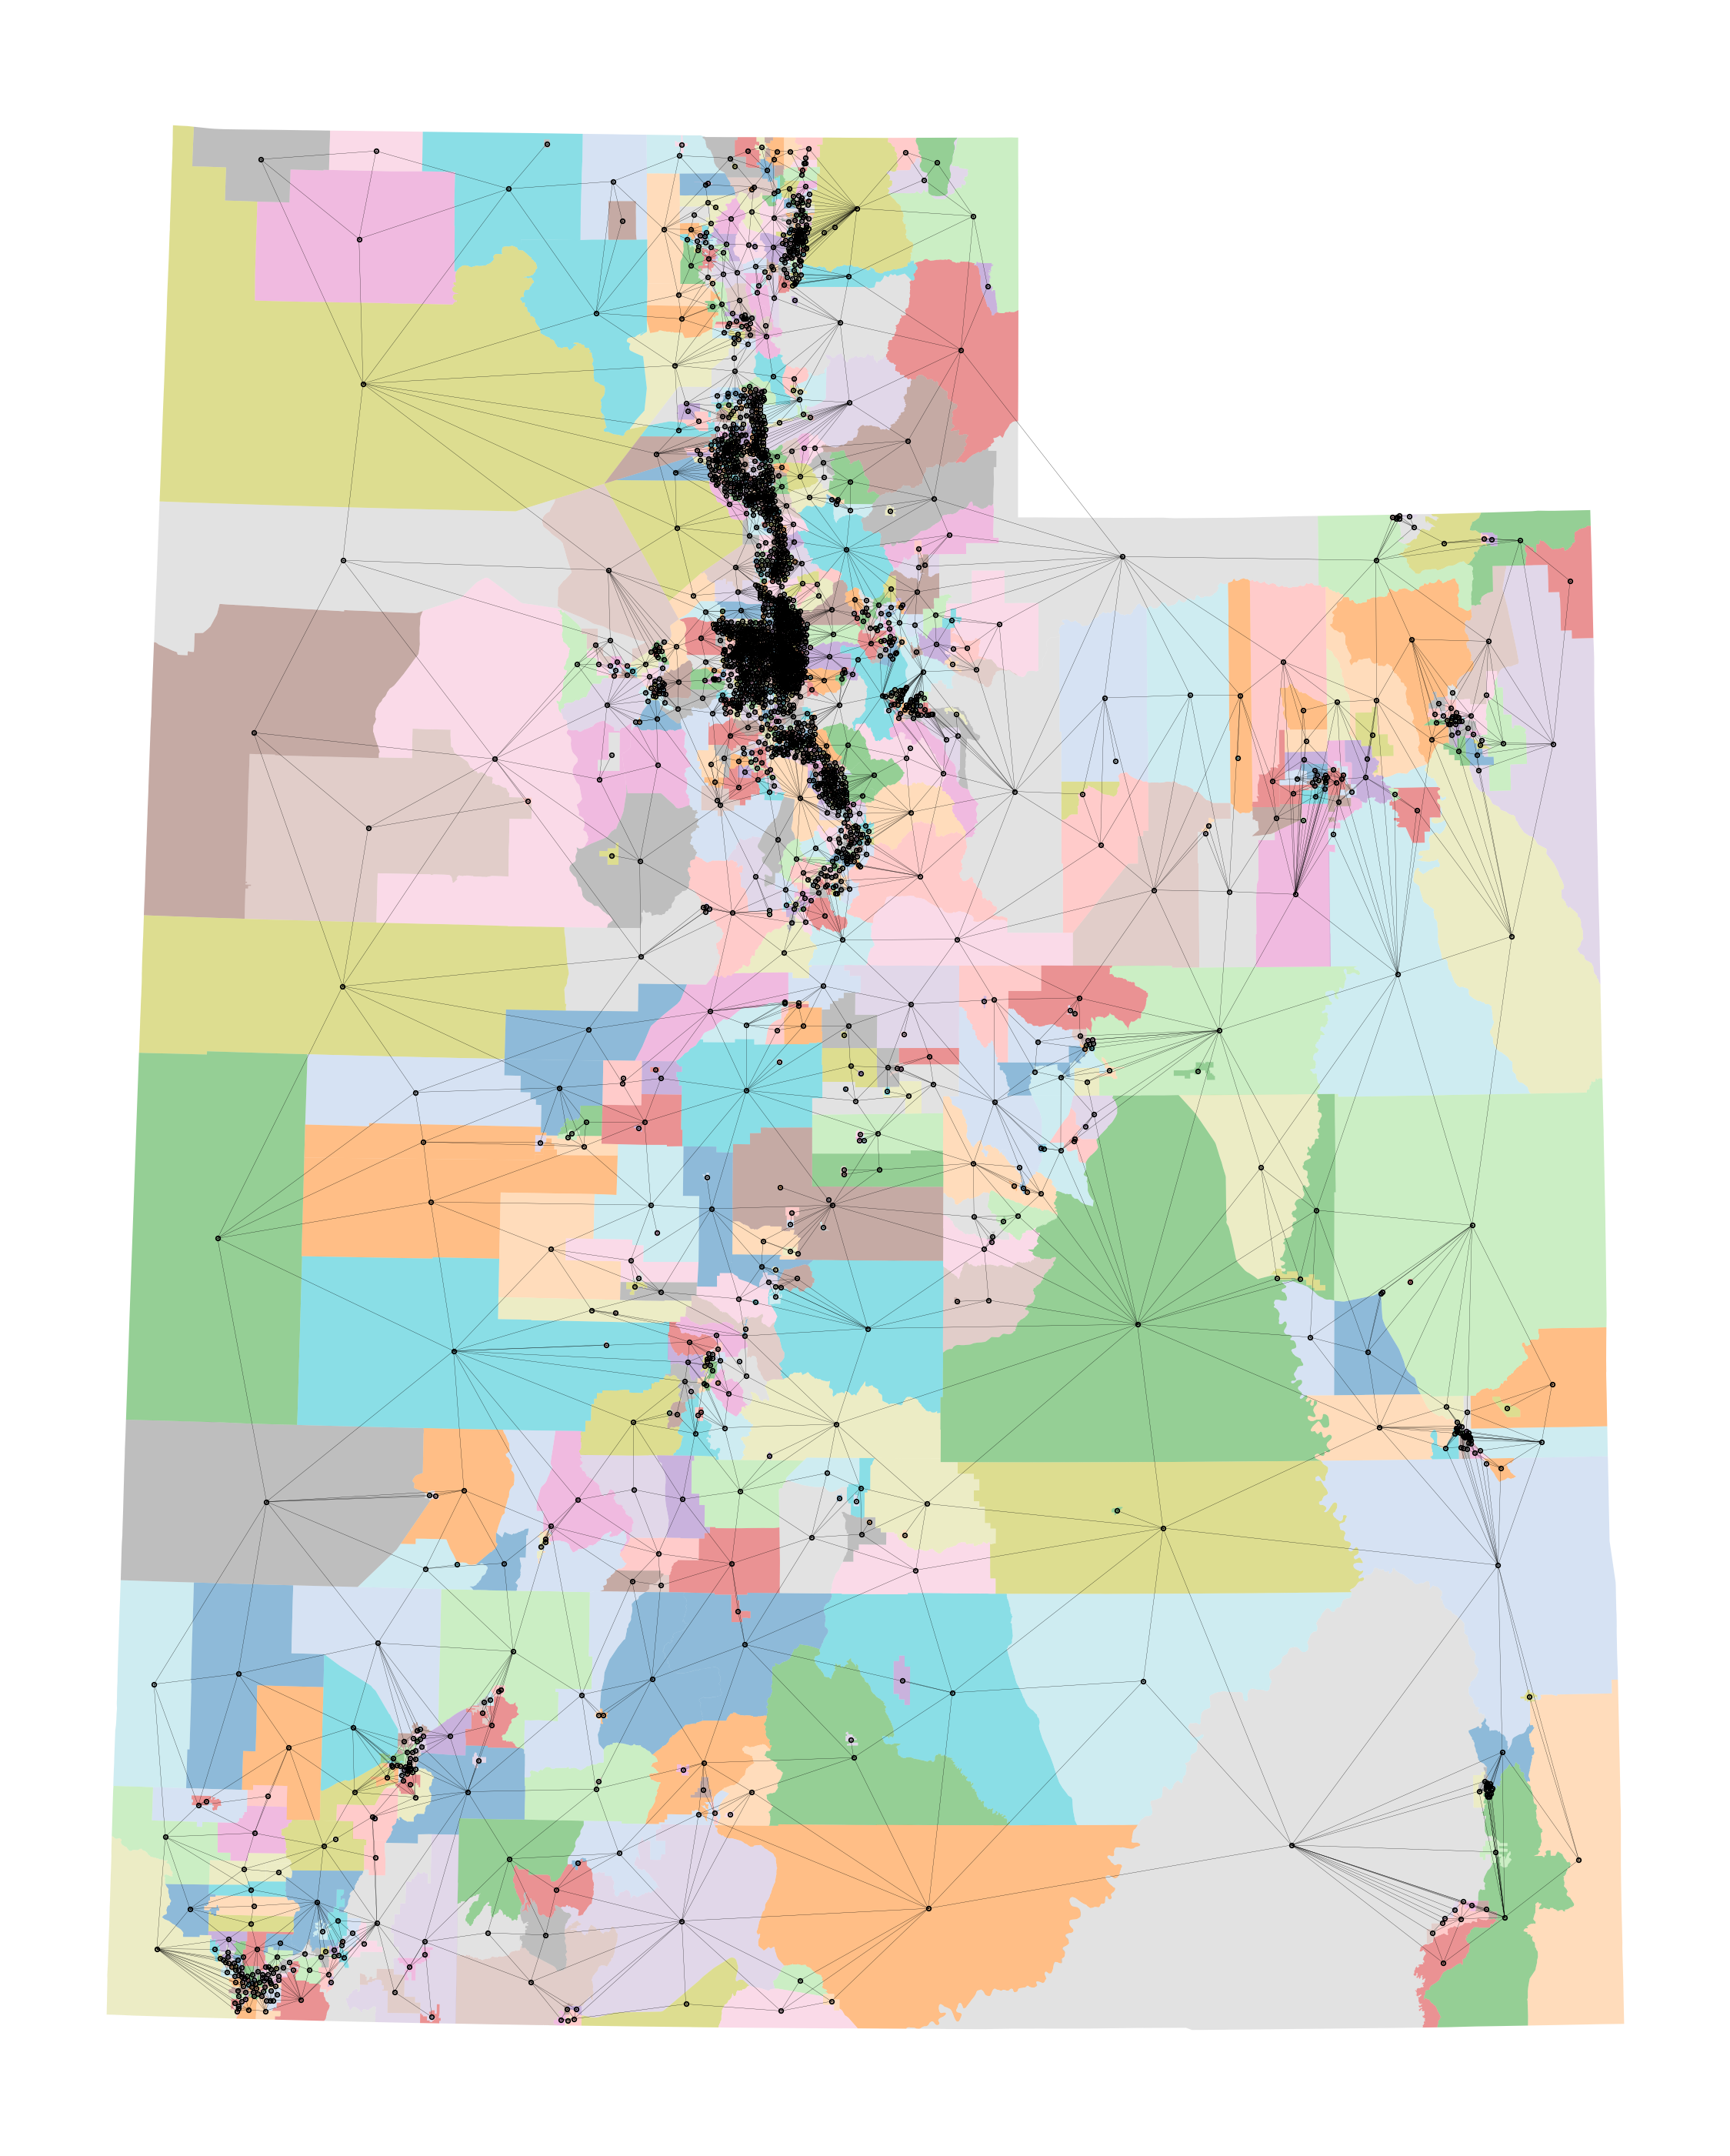

In [31]:
# Plot the original precincts
plot_graph(g, initial_partition.graph, dpi=400, size=7, save=False, savetitle='graph_before_merging1.png')

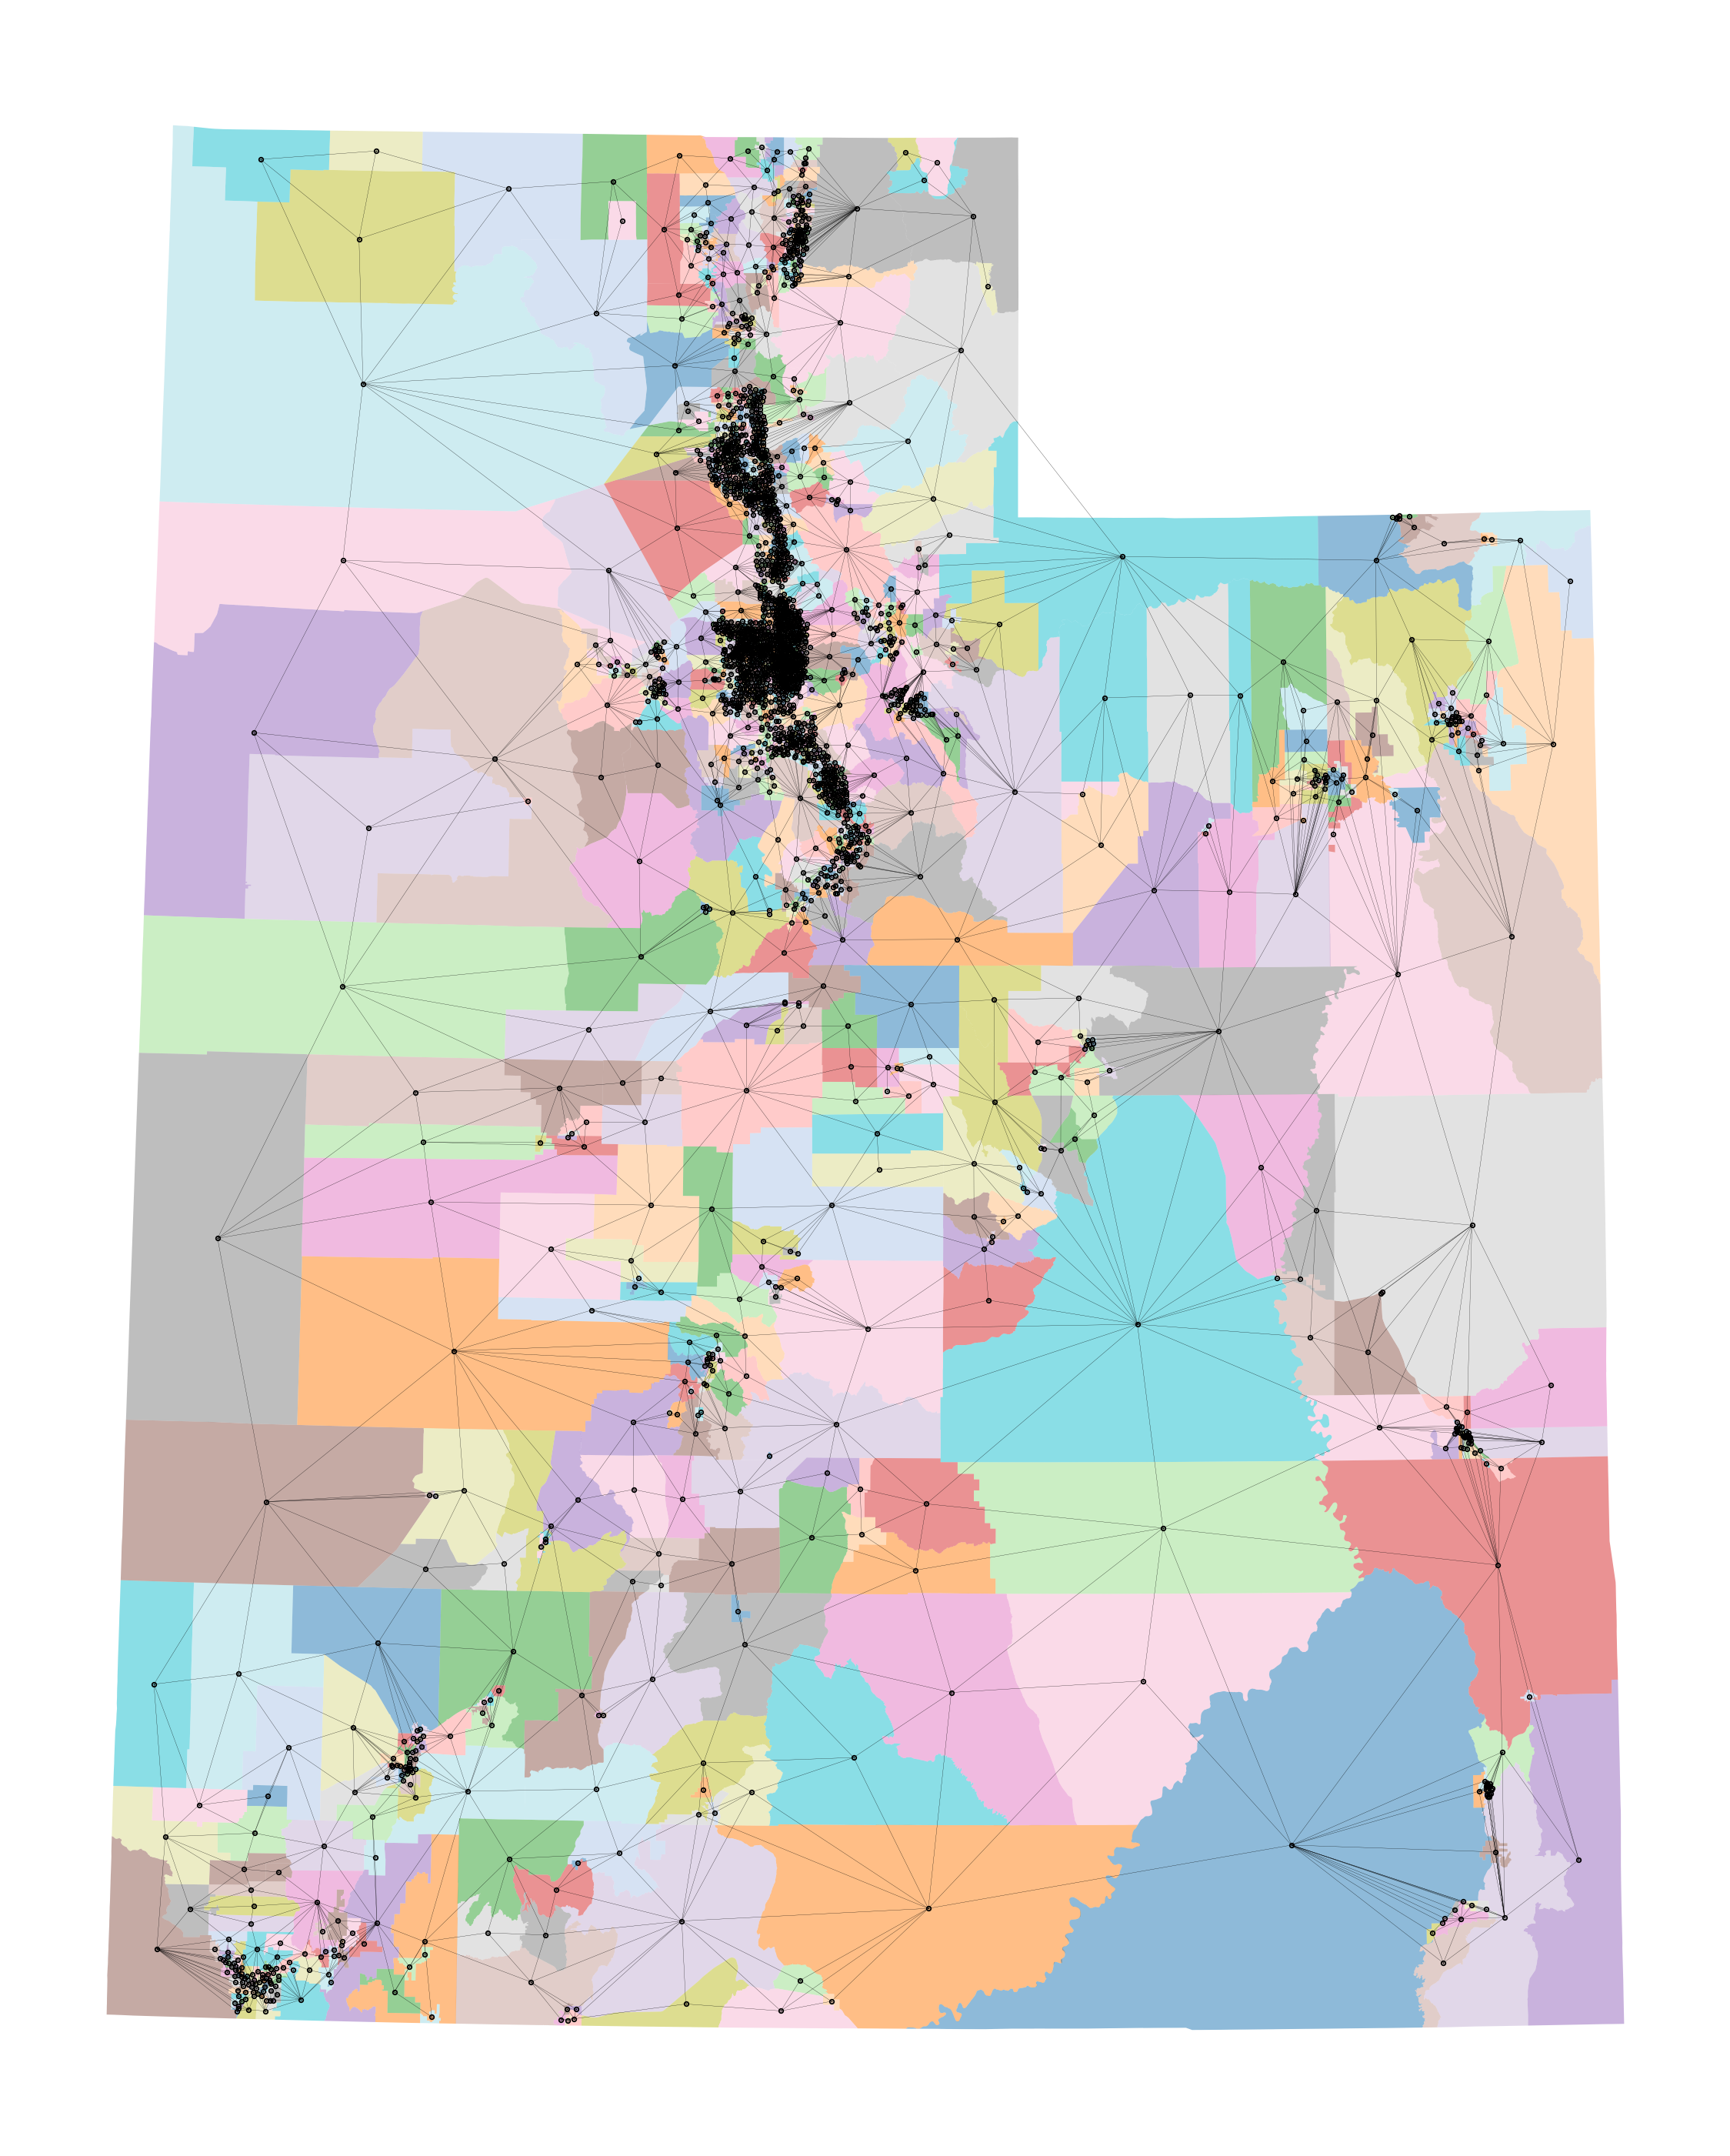

In [32]:
# Plot with isolated precincts removed
plot_graph(merged2, new_graph, dpi=400, size=7, save=False, savetitle='graph_after_merging1.png')